In [2]:
if(!require('igraph')) install.packages('igraph')
library('igraph')

# 4. Friend recommendation in personalized networks

In [38]:
fb_graph <- read.graph("facebook_combined.txt", format="edgelist", directed=FALSE)
V(fb_graph)$name <- V(fb_graph)
personal_415 <- induced_subgraph(fb_graph, c(415,neighbors(fb_graph,415)))
personal_415

IGRAPH b8fc134 UN-- 160 1857 -- 
+ attr: name (v/n)
+ edges from b8fc134 (vertex names):
 [1]  35--174  35--349 108--349 174--349 108--364 349--364 349--371 364--371
 [9] 349--374 364--374 371--374 349--375 364--375 371--375 374--375 108--377
[17] 349--377 364--377 371--377 374--377 375--377 349--379 364--379 371--379
[25] 374--379 375--379 377--379 349--392 374--392 375--392 377--392 379--392
[33] 349--395 377--395 379--395 392--395 349--396 371--396 374--396 377--396
[41] 349--401 374--401 377--401 379--401 392--401 395--401 396--401 349--413
[49] 364--413 371--413 374--413 375--413 377--413 379--413 392--413 396--413
[57] 401--413  35--415 108--415 174--415 349--415 364--415 371--415 374--415
+ ... omitted several edges

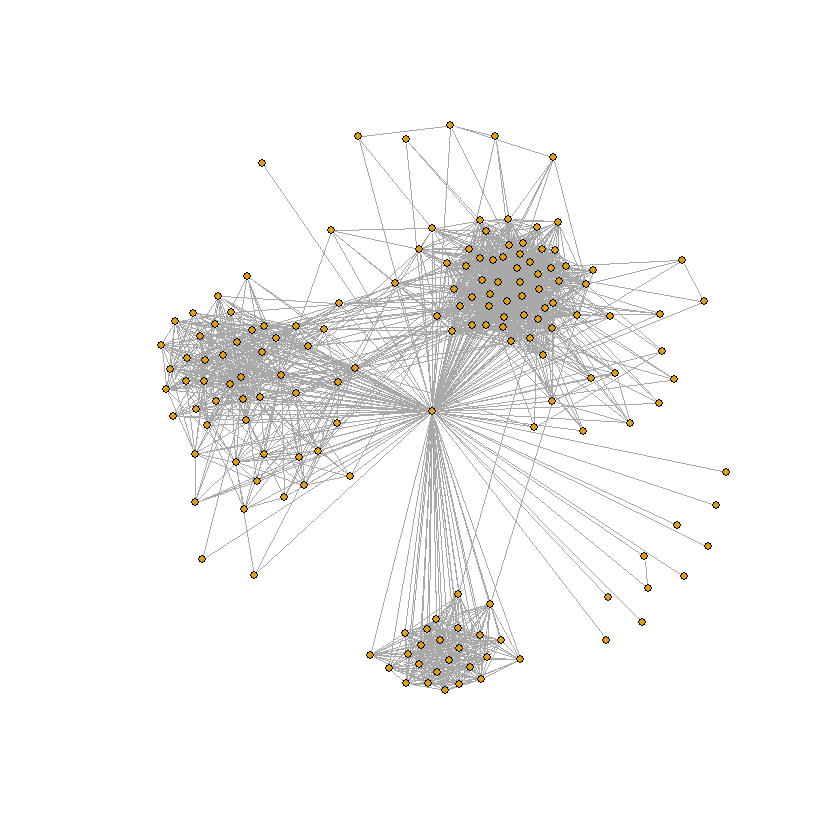

In [39]:
plot(personal_415,vertex.label=NA,vertex.size=3)

# 4.1 Neighborhood based measure

In [62]:
# Common Neighbor measure between node i and node j
common_neighbors <- function (graph, i, j) {
    # i, j: node index in V(graph), not node ID in fb_graph
    return (length(intersect(neighbors(graph, i), neighbors(graph, j))))
}

In [63]:
# Jaccard measure between node i and node j
jaccard <- function (graph, i, j) {
    # i, j: node index in V(graph), not node ID in fb_graph
    intersect_num <- length(intersect(neighbors(graph, i), neighbors(graph, j)))
    union_num <- length(union(neighbors(graph, i), neighbors(graph, j)))
    return (intersect_num/union_num)
}

In [86]:
# Adamic-Adar measure between node i and node j
adamic_adar <- function (graph, i, j) {
    # i, j: node index in V(graph), not node ID in fb_graph
    intersect_nodes <- intersect(neighbors(graph, i), neighbors(graph, j))
    result <- 0
    for (intersect_node in intersect_nodes){
        result <- result + 1/log(length(neighbors(graph, intersect_node)))
    }
    return (result)
}

In [288]:
# Combine three neighbor measure methods together
neighbor_measure <- function (graph, i, j, method="jaccard") {
    # i, j: node index in V(graph), not node ID in fb_graph
    if (method == "common_neighbors") {
        return (common_neighbors(graph, i, j))
    }
    else if (method == "jaccard") {
        return (jaccard(graph, i, j))
    }
    else if (method == "adamic_adar") {
        return (adamic_adar(graph, i, j))
    }
}

# 4.2 Friend recommendation using neighborhood based measures

In [316]:
# recommend friend based on neighbor measure
friend_rec <- function (graph, i, t = 1, method = "jaccard") {
    # i, return_node: node index in V(graph), not node ID
    # t: recommemd t new friends
    
    non_friends <- setdiff(V(graph), c(as.numeric(neighbors(graph, i)), i))
    
    measure_list <- c()
    for (non_friend in non_friends) {
        measure_list <- c(measure_list, neighbor_measure(graph, i, non_friend, method=method))
    }
    
    return (non_friends[sort(measure_list, decreasing=TRUE, index.return=TRUE)$ix[1:t]])
}

# 4.3 Creating the list of users

# Question 16

In [178]:
# Nr: list of user, index in personal_415
Nr <- as.numeric(which(degree(personal_415)==24))
cat("node index:",Nr,"\n")
cat("node ID:",V(personal_415)[Nr]$name,"\n")
cat("|Nr| = ", length(Nr), "\n")

node index: 31 53 75 90 93 102 118 133 134 136 137 
node ID: 497 579 601 616 619 628 644 659 660 662 663 
|Nr| =  11 


# 4.4 Average accuracy of friend recommendation algorithm

In [418]:
# accuracy function
accuracy <- function (graph, i, method="jaccard") {
    # i: node index in V(graph), not node id in fb_graph
    graph_tmp <- graph
    Ri <- c()
    while (length(Ri)==0) {
        for (idx in as.numeric(neighbors(graph, i))) {
            if (runif(1,0,1) <= 0.25) {
                graph_tmp <- delete_edges(graph_tmp, get.edge.ids(graph_tmp,c(i,idx)))
                Ri <- c(Ri, idx)
            }
        }
        Pi <- friend_rec(graph_tmp, i, length(Ri), method)        
    }
    return (length(intersect(Pi, Ri))/length(Ri))
}

In [289]:
total_accuracy <- function (graph, i, method="jaccard", iter = 10) {
    result <- 0
    for (tmp in 1:iter) {
        result <- result + accuracy(graph, i, method=method)
    }
    return (result/iter)
}

In [432]:
accuracy_result <- data.frame()
for (method in c("common_neighbors", "jaccard", "adamic_adar")){
    ave <- 0
    for (i in Nr){
        accuracy_tmp <- total_accuracy(personal_415, i, iter=50, method=method)
        accuracy_result[toString(V(personal_415)[i]$name), method] <- accuracy_tmp
    }
}
accuracy_result

,common_neighbors,jaccard,adamic_adar
497,0.3038651,0.1606371,0.3524957
579,0.9900000,0.9395144,0.9899206
601,0.9049127,0.8546667,0.8875159
616,0.8214437,0.7710476,0.8361746
619,0.4383423,0.5301508,0.4157215
628,1.0000000,0.9501263,0.9752778
644,0.8888413,0.9027460,0.8969517
659,0.9971429,0.9273961,0.9678333
660,0.9937778,0.9446190,0.9876667
662,0.8944683,0.9042937,0.8819444


In [453]:
rowAve <- rowSums(accuracy_result)/3
rowAve
colAve <- colSums(accuracy_result)/11
colAve
ave(colAve)[1]

497       579       601       616       619       628       644       659 
0.2723326 0.9731450 0.8823651 0.8095553 0.4614049 0.9751347 0.8961797 0.9641241 
      660       662       663 
0.9753545 0.8935688 0.9456419

common_neighbors          jaccard      adamic_adar 
       0.8344732        0.8002473        0.8331358

common_neighbors 
       0.8226188